In [164]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.impute import KNNImputer
from scipy.optimize import curve_fit


In [165]:
print(os.listdir())

['EastLothian_data.csv', 'Edinburgh_data.csv', 'Fife_data.csv', 'forecast.csv', 'ind_homes', 'Midlothian_data.csv', 'monte_carlo_temp.ipynb', 'weather data.ipynb', 'WestLothian_data.csv']


In [166]:
weather_data = pd.read_csv('forecast.csv', delimiter='\t', parse_dates=['dateforecastfor', 'dateforecastmade'], index_col='dateforecastfor')

In [167]:
weather_data = weather_data.sort_index()

In [168]:
weather_data

,locationid,dateforecastmade,maxtemp,mintemp,tempunit,conditions,conditionsicon
dateforecastfor,,,,,,,
2016-08-10,Edinburgh,2016-08-10,13,12,C,Rain,http://icons.wxug.com/i/c/k/rain.gif
2016-08-11,Edinburgh,2016-08-11,17,14,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif
2016-08-12,Edinburgh,2016-08-12,17,12,C,Chance of Rain,http://icons.wxug.com/i/c/k/chancerain.gif
2016-08-13,Edinburgh,2016-08-13,16,11,C,Mostly Cloudy,http://icons.wxug.com/i/c/k/mostlycloudy.gif
2016-08-14,Edinburgh,2016-08-14,17,9,C,Partly Cloudy,http://icons.wxug.com/i/c/k/partlycloudy.gif
...,...,...,...,...,...,...,...
2018-12-30,EastLothian,2018-12-27,11,7,C,Partly Cloudy,http://icons.wxug.com/i/c/k/partlycloudy.gif
2018-12-30,Edinburgh,2018-12-30,11,7,C,Partly Cloudy,http://icons.wxug.com/i/c/k/partlycloudy.gif
2018-12-30,WestLothian,2018-12-27,9,6,C,Overcast,http://icons.wxug.com/i/c/k/cloudy.gif


In [169]:
min_max_temp = weather_data[['locationid', 'maxtemp', 'mintemp']]

INSPECT MISSING GAPS FOR EACH LOCATION

In [172]:
location_dataframes = {}
for loc in min_max_temp['locationid'].unique().tolist():
    loc_data = min_max_temp[min_max_temp['locationid'] == loc]
    
    min_date = loc_data.index.min()
    max_date = loc_data.index.max()
    
    full_date_range = pd.date_range(start=min_date, end=max_date)
    
    available_dates = loc_data.index
    
    missing_dates = full_date_range.difference(available_dates)
    
    print(f"Location: {loc}")
    print(f"Min Date: {min_date}")
    print(f"Max Date: {max_date}")
    print(f"Total Missing Dates: {len(missing_dates)}")
    print(f"Missing Date Range: {missing_dates.min()} to {missing_dates.max()}" if len(missing_dates) > 0 else "No missing dates")
    print("")
    
    # create a single df for each location including the missing dates
    full_dates_df = pd.DataFrame({'date': full_date_range})
    full_dates_df.set_index('date', inplace=True)
    
    # Merge the complete date range with the location data
    merged_data = full_dates_df.merge(loc_data, left_index=True, right_index=True, how='left')
    
    location_dataframes[f"{loc}_data"] = merged_data
    
    merged_data.to_csv(f"{loc}_data.csv")
    
    print(f"DataFrame created and saved for location: {loc}")

Location: Edinburgh
Min Date: 2016-08-10 00:00:00
Max Date: 2018-12-30 00:00:00
Total Missing Dates: 55
Missing Date Range: 2018-02-17 00:00:00 to 2018-04-12 00:00:00

DataFrame created and saved for location: Edinburgh
Location: Fife
Min Date: 2017-11-28 00:00:00
Max Date: 2018-12-30 00:00:00
Total Missing Dates: 99
Missing Date Range: 2017-12-03 00:00:00 to 2018-12-27 00:00:00

DataFrame created and saved for location: Fife
Location: EastLothian
Min Date: 2017-11-28 00:00:00
Max Date: 2018-12-30 00:00:00
Total Missing Dates: 94
Missing Date Range: 2017-12-03 00:00:00 to 2018-12-27 00:00:00

DataFrame created and saved for location: EastLothian
Location: WestLothian
Min Date: 2017-11-28 00:00:00
Max Date: 2018-12-30 00:00:00
Total Missing Dates: 57
Missing Date Range: 2018-02-16 00:00:00 to 2018-12-15 00:00:00

DataFrame created and saved for location: WestLothian
Location: Midlothian
Min Date: 2017-11-28 00:00:00
Max Date: 2018-12-30 00:00:00
Total Missing Dates: 66
Missing Date Rang

In [173]:
for loc, items in location_dataframes.items():
     globals()[f"{loc.lower()}"] = items.drop(columns=['locationid'])

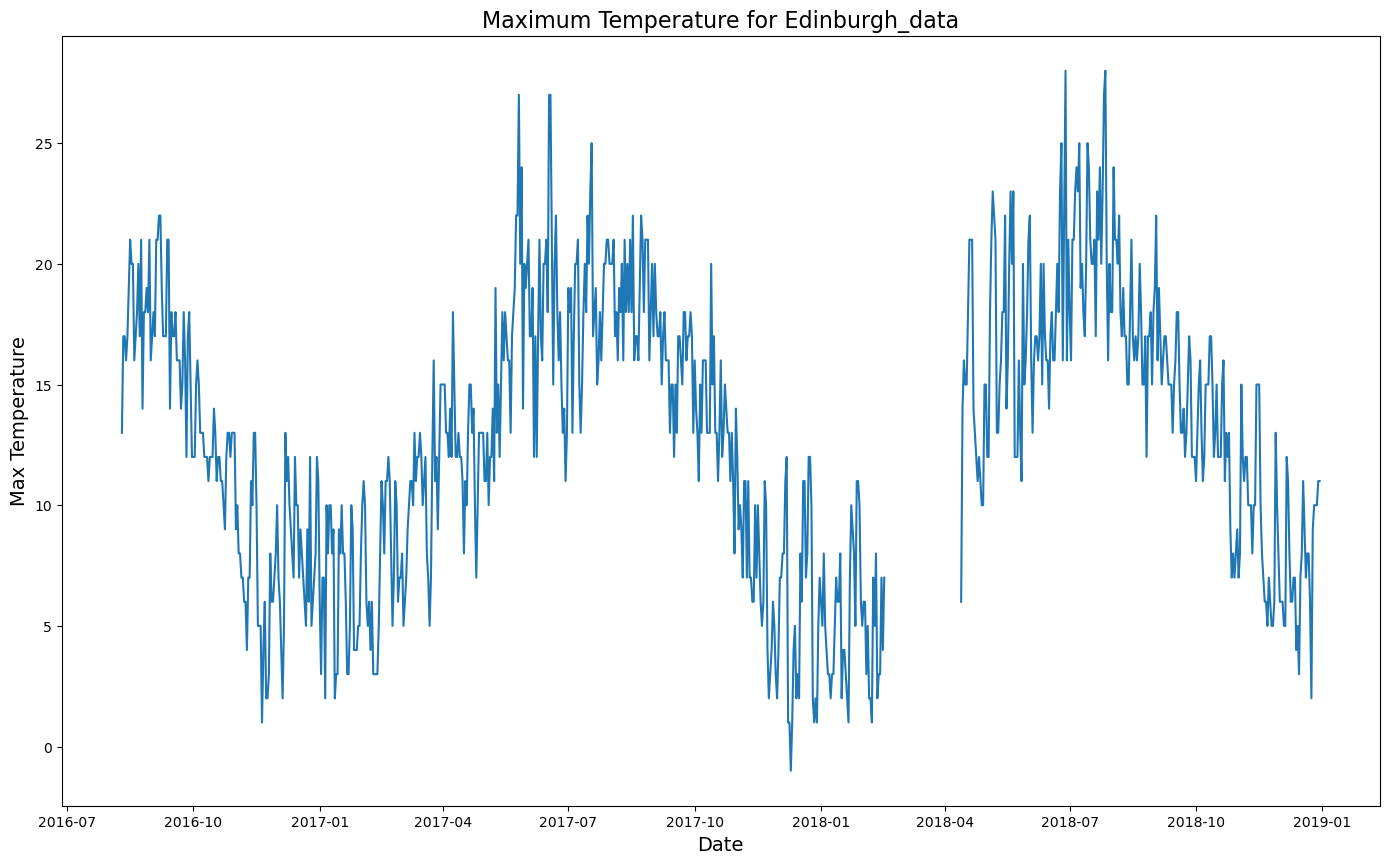

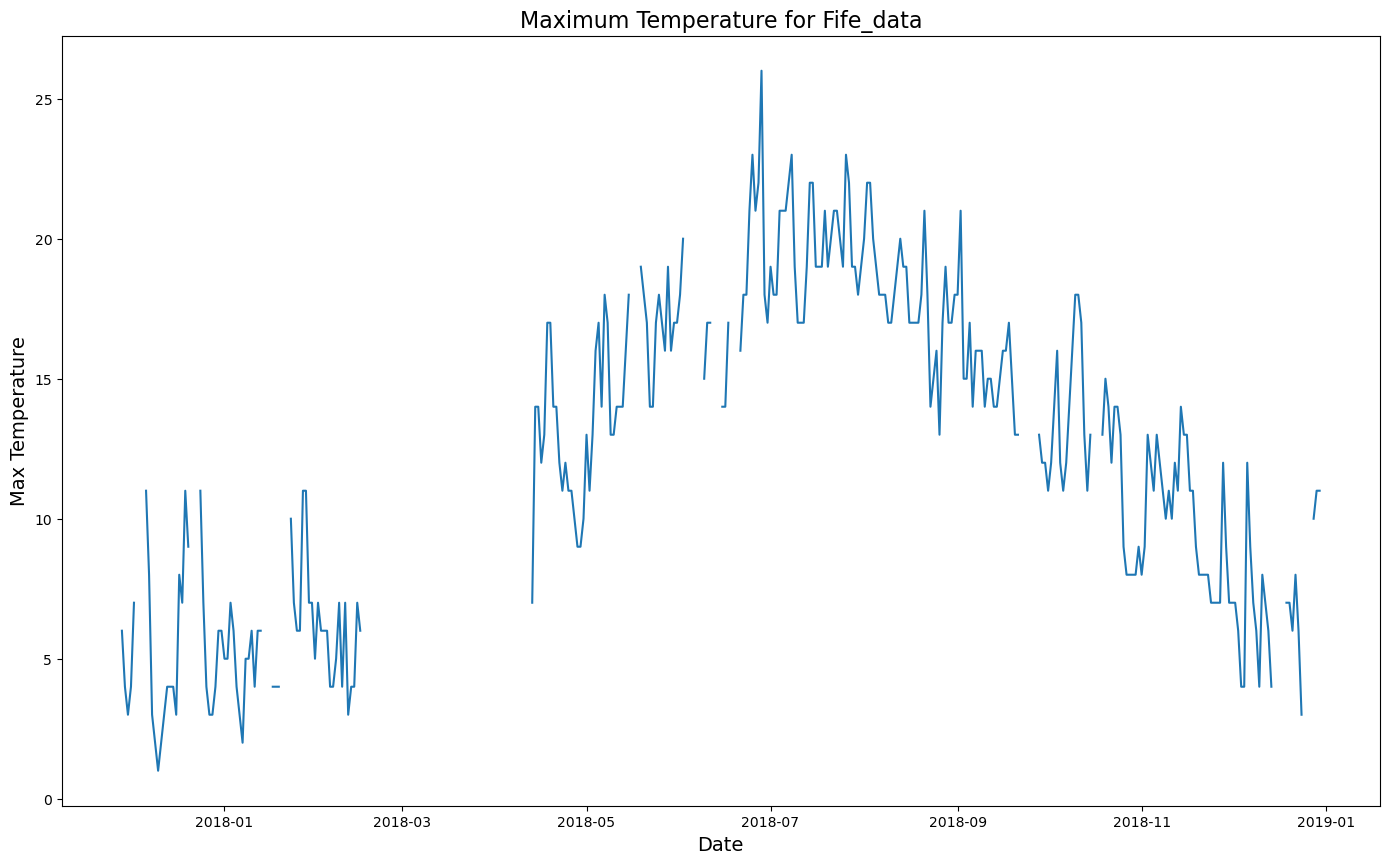

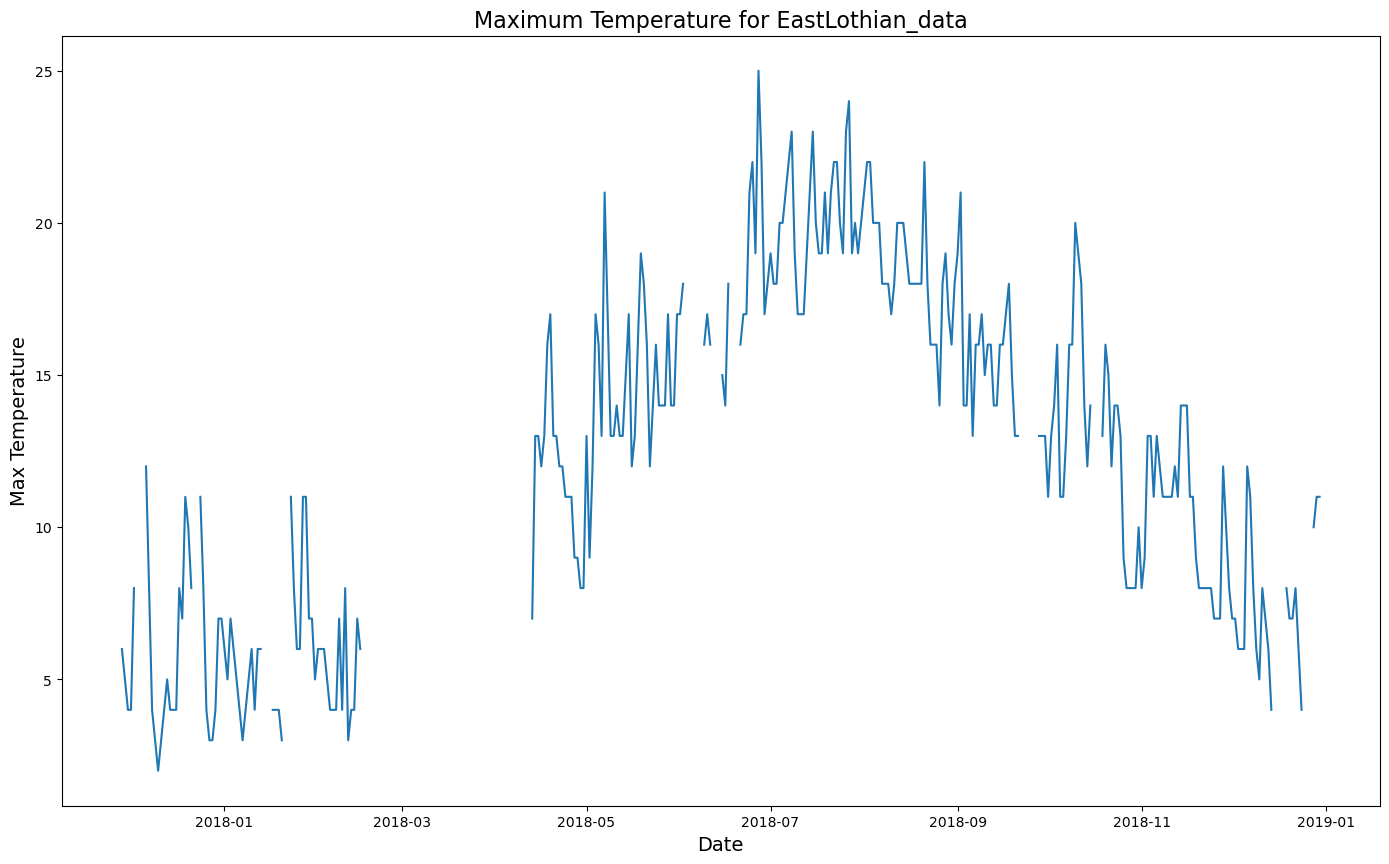

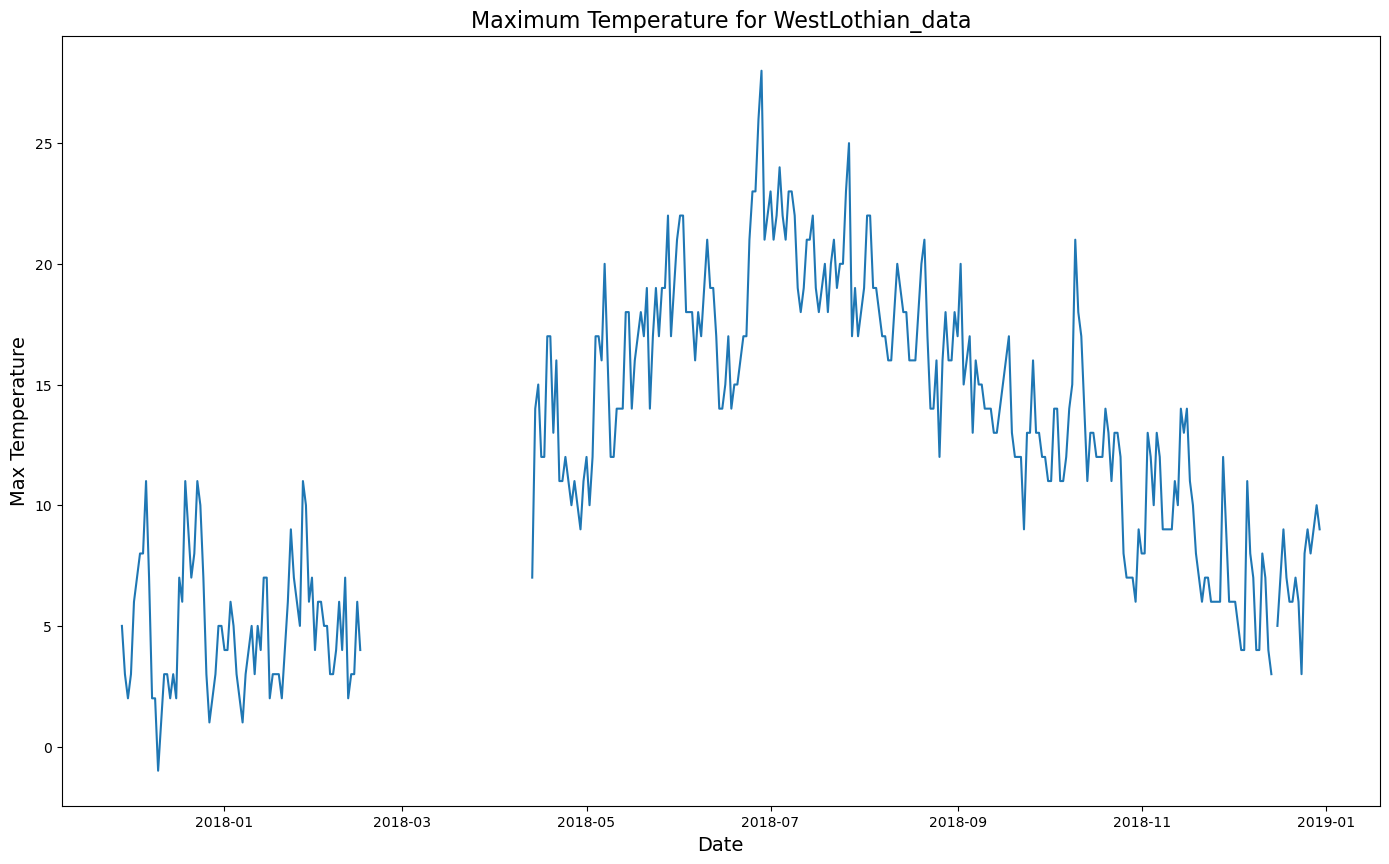

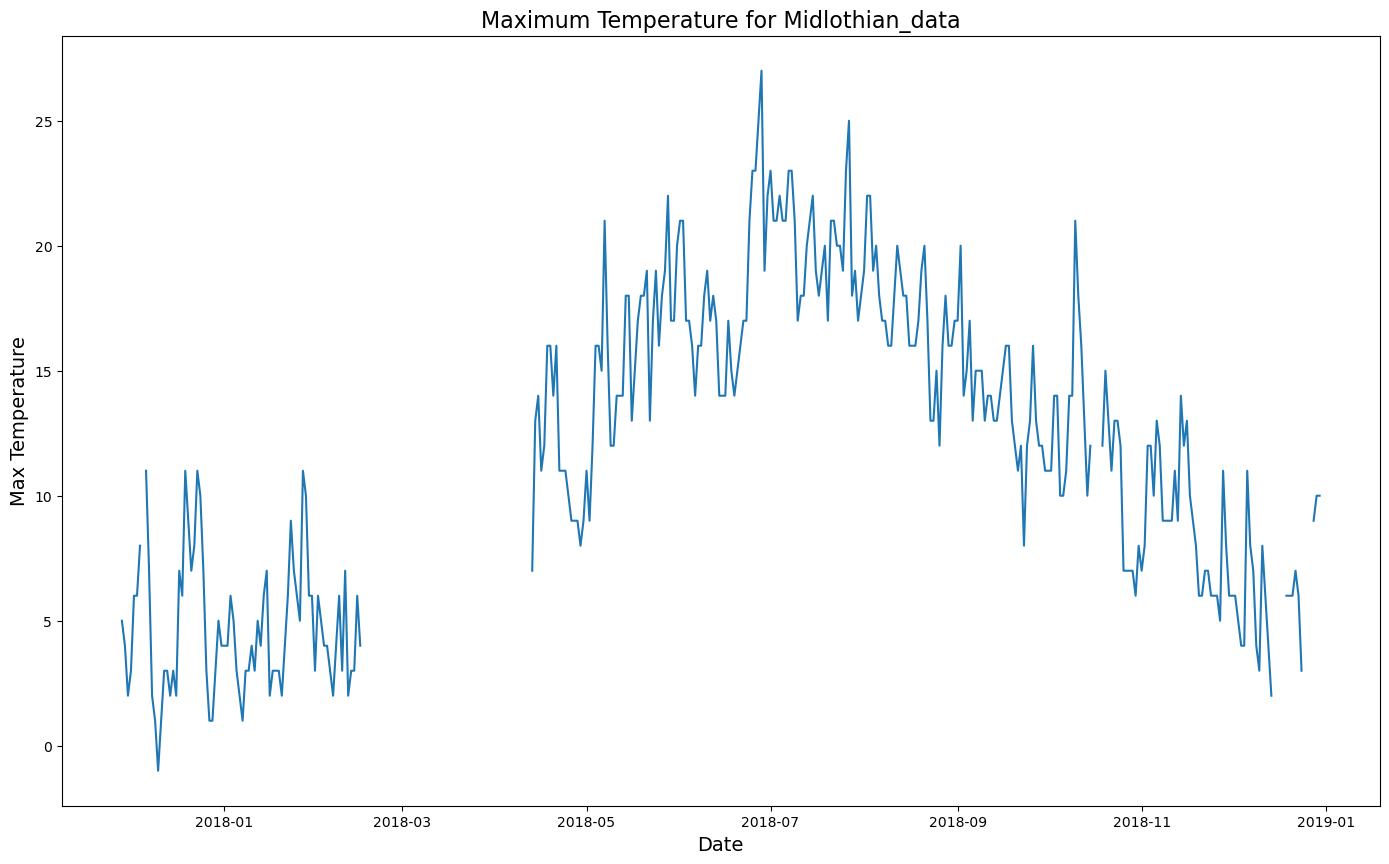

In [174]:
for loc, items in location_dataframes.items():
    plt.figure(figsize=(17,10))
    plt.plot(items.index, items['maxtemp'], linestyle='-')
    plt.title(f"Maximum Temperature for {loc}", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Max Temperature", fontsize=14)
    plt.show()

FUNCTION TO IMPUTE MISSING VALUES FOR DAILY TIMESTAMPS DATA

In [176]:
# function for fourier series
def fourier_series(x, *a):
    """General Fourier series function."""
    ret = a[0] / 2  # The constant term
    n_terms = (len(a) - 1) // 2
    for i in range(n_terms):
        ret += a[1 + i] * np.sin((i + 1) * x * 2 * np.pi / 365) + a[1 + n_terms + i] * np.cos((i + 1) * x * 2 * np.pi / 365)
    return ret

# function that uses the fourier series predictions on the observed data to calculate the residuals with the observed data and choose a random residual to add it in the predicted values to account for ups and downs
def add_residual_variation(predicted, residuals):
    """Add random residual noise to predicted values."""
    if len(residuals) > 0:
        noise = np.random.choice(residuals, size=len(predicted), replace=True)
        return predicted + noise
    return predicted


def impute_gaps(location_data, column_to_impute, small_gap_threshold=6, debug=False):
    # Ensure the index is datetime
    if not isinstance(location_data.index, pd.DatetimeIndex):
        location_data.index = pd.to_datetime(location_data.index)

    # Mark missing values for the specified column
    is_missing_col = f'is_missing_{column_to_impute}'
    gap_group_col = f'gap_group_{column_to_impute}'

    location_data[is_missing_col] = location_data[column_to_impute].isna()

    # Identify groups of consecutive missing values
    location_data[gap_group_col] = (
        location_data[is_missing_col] != location_data[is_missing_col].shift()  # keeps track of the previous row's record (shift) and allows the comparison with the current row to identify if the rows are in the same group (either True or False)
    ).cumsum() #  here cumsum accounts for the comparison --> if the comparison is True is means that we have a shift to a new group (cumsum increases) while if the comparison is false it means we are in the same group so the cumsum remains the same --> this way we group the rows based on the comparisons we did

    # Calculate the size of each gap group
    gap_sizes = location_data.groupby(gap_group_col).agg(
        is_missing=(is_missing_col, 'first'), # stores True or False in the is_missing column to determine if a missing gap starts or no
        gap_size=(is_missing_col, 'sum') # 
    ).reset_index()

    if debug:
        print(f"Gap Sizes for {column_to_impute}:")
        print(gap_sizes)

    # Handle small gaps (≤ small_gap_threshold)
    small_gaps = gap_sizes[gap_sizes['is_missing'] & (gap_sizes['gap_size'] <= small_gap_threshold)]
    if debug:
        print(f"Identified small gaps (≤ {small_gap_threshold}): {len(small_gaps)}")

    for _, row in small_gaps.iterrows():
        gap_group = row[gap_group_col]
        gap_indices = location_data[location_data[gap_group_col] == gap_group].index
        if debug:
            print(f"Small gap group {gap_group} from {gap_indices[0]} to {gap_indices[-1]}")

        # Apply spline interpolation for small gaps
        location_data.loc[gap_indices, column_to_impute] = location_data[column_to_impute].interpolate(
            method='spline', order=3
        )

    # Handle large gaps (> small_gap_threshold)
    large_gaps = gap_sizes[gap_sizes['is_missing'] & (gap_sizes['gap_size'] > small_gap_threshold)]
    if debug:
        print(f"Identified large gaps (> {small_gap_threshold}): {len(large_gaps)}")

    for _, row in large_gaps.iterrows():
        gap_group = row[gap_group_col]
        gap_indices = location_data[location_data[gap_group_col] == gap_group].index
        gap_start = gap_indices[0]
        gap_end = gap_indices[-1]

        if debug:
            print(f"gap_start: {gap_start}, gap_end: {gap_end}")
            print(f"Data index type: {location_data.index}")

        try:
            # Extract available data (excluding missing values)
            available_data = location_data[~location_data[column_to_impute].isna()]
            x = (available_data.index - available_data.index[0]).days.values # transform dates in numerical format (by day)
            y = available_data[column_to_impute].values # extract the values of the existing data for the selected column

            # Fit a Fourier series
            n_harmonics = 3  # Number of harmonics to capture seasonal variation (determines how many sine and cosine functions are used to capture the seasonal variation)
            p0 = [np.mean(y)] + [0] * (2 * n_harmonics)  # Initial guess (necessary for the curve_fit function to start the optimisation)
            params, _ = curve_fit(fourier_series, x, y, p0=p0) # use the curve_fit to extract the optimal params for the Fourier Series that minimise the difference between the observed and the fourier predicted values (minimises the sum of square residuals)
            
            # Explanation of how we define harmonics (based on the visual representation of the data:
            # The first harmonic captures the broad seasonal cycle (e.g., summer to winter transitions).
            # The second harmonic refines this by accounting for mid-season shifts.
            # The third harmonic focuses on even smaller variations, like monthly changes or irregularities within seasons.
            # the more harmonics we add the more the detail but then the model is prone to overfitting
            
            #COSINE: It starts at a peak (1), dips to zero, drops to a trough (−1), returns to zero, and completes a cycle back at 1 ! better for long-term oscillations
            #SINE: It starts at zero, rises to a peak (1), falls to zero, dips to a trough (−1), and completes a cycle back at 0 ! better for mid-season oscillations since it starts from zero
            # Since there two together are orthogonal, they capture different variations
            

            
            # Calculate residuals for the 
            y_fit = fourier_series(x, *params) # params = a0, ak, bk. These represent the average level of the data (a0), the amplitude of the  k-term cosine (ak) and the amplitude of the k-th sine term (bk)
            residuals = y - y_fit

            # Predict for the gap indices
            x_pred = (gap_indices - available_data.index[0]).days.values # extract the dates in numerical format for the missing timestamps
            y_pred = fourier_series(x_pred, *params) # apply the fourier series to predict the missing gaps using the optimised params that were obtained from the fitted fourier model on the existing data

            # Add residual-based noise 
            y_pred_with_noise = add_residual_variation(y_pred, residuals) # we add to the predicted values of the missing gaps, a random noise that was obtained based on the residuals that were calculated between the predicted (from fourier series) and the observed data

            # Assign predicted values
            location_data.loc[gap_indices, column_to_impute] = y_pred_with_noise

            if debug:
                print(f"Fourier series imputed values with noise for gap group {gap_group}:")
                print(y_pred_with_noise)

        except Exception as e:
            if debug:
                print(f"Fourier series failed for gap group {gap_group}: {e}")
            # Fallback to KNN
            print(f"Fallback to KNN for gap group {gap_group}.")
            knn_imputer = KNNImputer(n_neighbors=3)
            location_data[column_to_impute] = knn_imputer.fit_transform(
                location_data[[column_to_impute]]
            ).flatten()

    # Drop temporary columns specific to the current imputation
    location_data.drop(columns=[is_missing_col, gap_group_col], inplace=True)

    # Final debugging
    if debug:
        print(f"Final missing values after imputation for {column_to_impute}: {location_data[column_to_impute].isna().sum()}")

    return location_data


# Apply imputation for each location
for loc, data in location_dataframes.items():
    print(f"Processing location: {loc}")
    
    # Impute 'mintemp'
    location_dataframes[loc] = impute_gaps(data, column_to_impute='mintemp', debug=True)
    print(f"Processed missing data for mintemp for location: {loc}")

    # Impute 'maxtemp'
    location_dataframes[loc] = impute_gaps(location_dataframes[loc], column_to_impute='maxtemp', debug=True)
    print(f"Processed missing data for maxtemp for location: {loc}")


Processing location: Edinburgh_data
Gap Sizes for mintemp:
   gap_group_mintemp  is_missing  gap_size
0                  1       False         0
1                  2        True        55
2                  3       False         0
Identified small gaps (≤ 6): 0
Identified large gaps (> 6): 1
gap_start: 2018-02-17 00:00:00, gap_end: 2018-04-12 00:00:00
Data index type: DatetimeIndex(['2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13',
               '2016-08-14', '2016-08-15', '2016-08-16', '2016-08-17',
               '2016-08-18', '2016-08-19',
               ...
               '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24',
               '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28',
               '2018-12-29', '2018-12-30'],
              dtype='datetime64[ns]', name='date', length=873, freq=None)
Fourier series imputed values with noise for gap group 2:
[ 9.52838055e+00  8.45994358e+00  7.75616807e+00 -4.00326444e+00
  2.12187896e+00  4.78471144e+00  4.510760

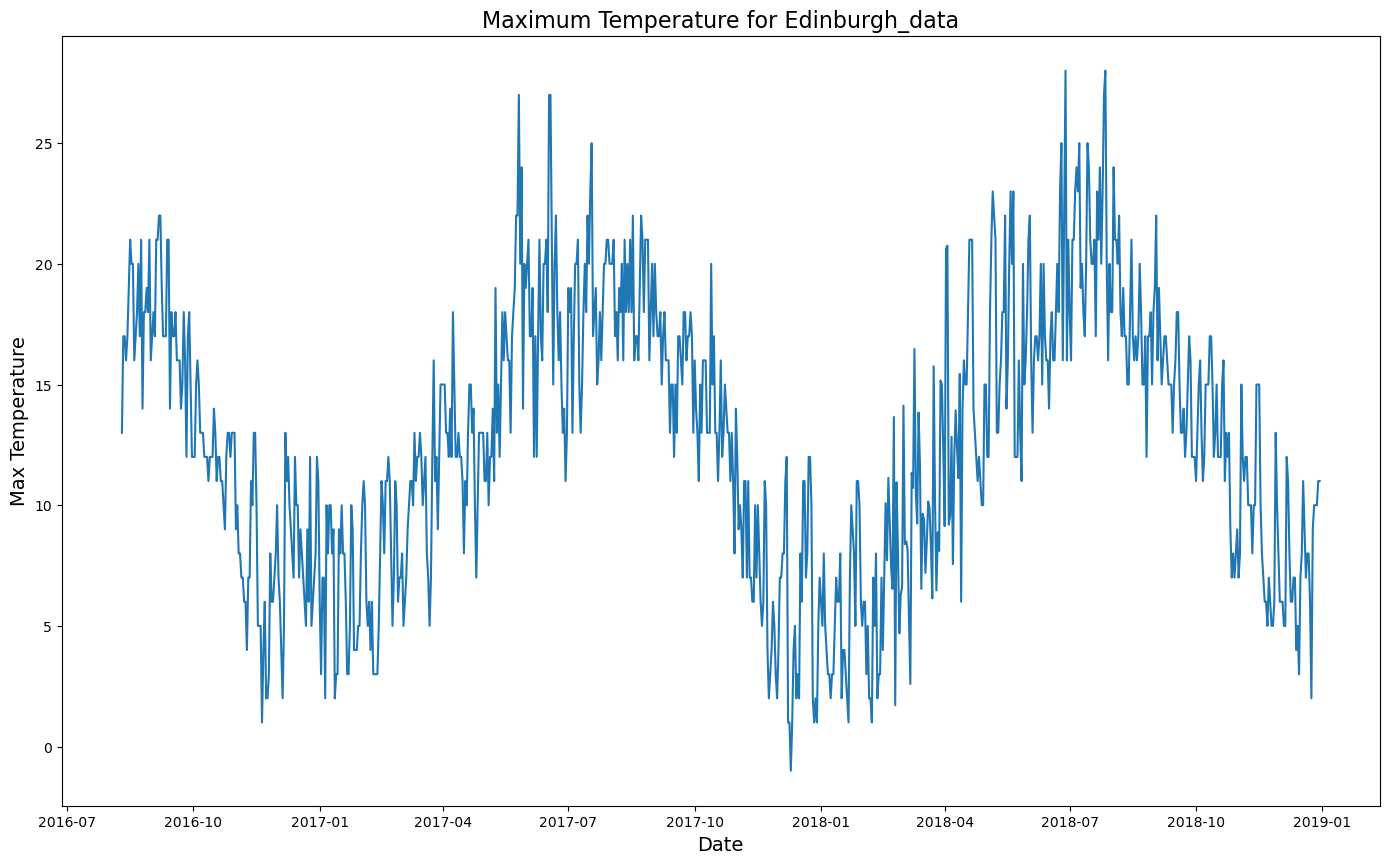

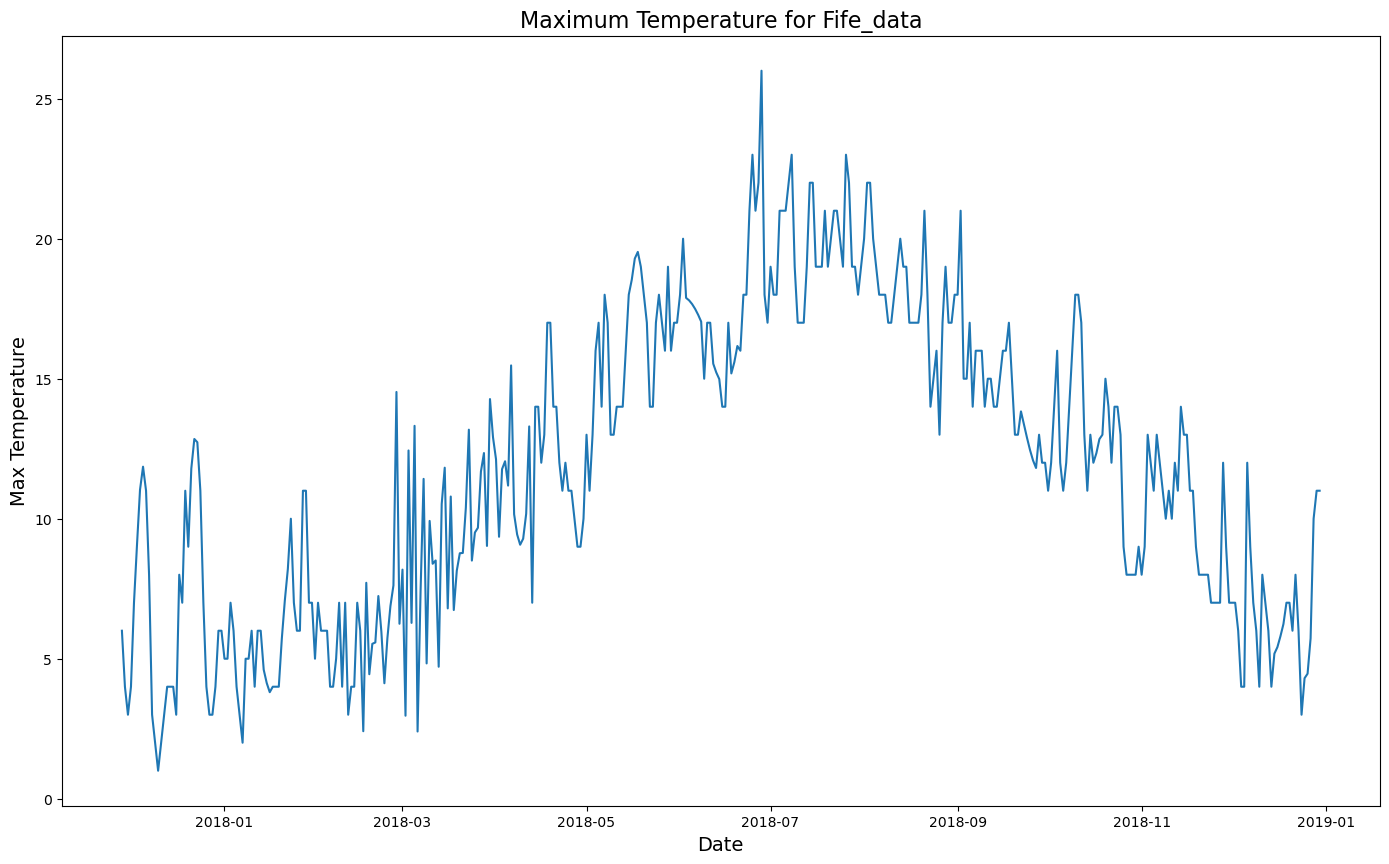

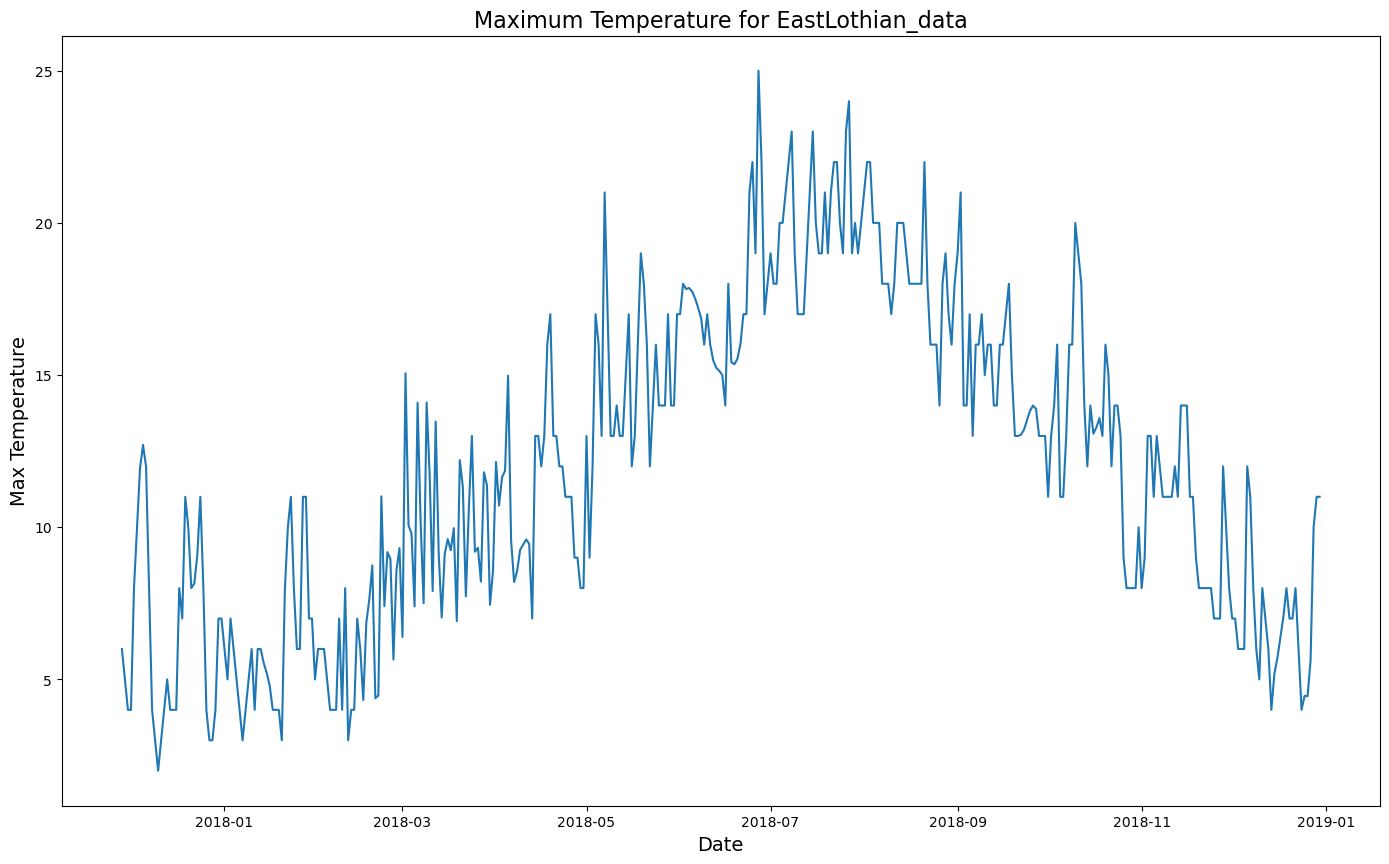

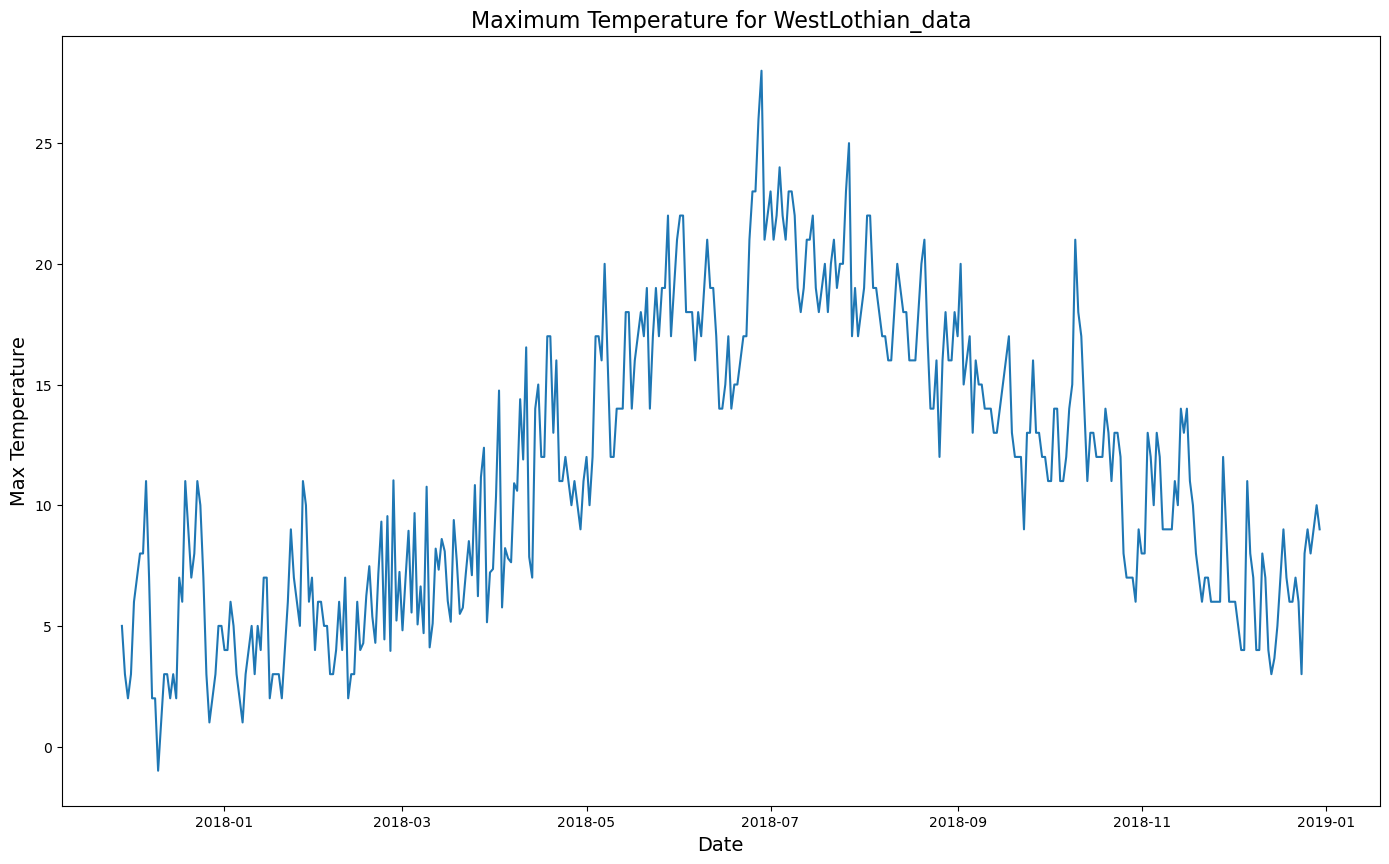

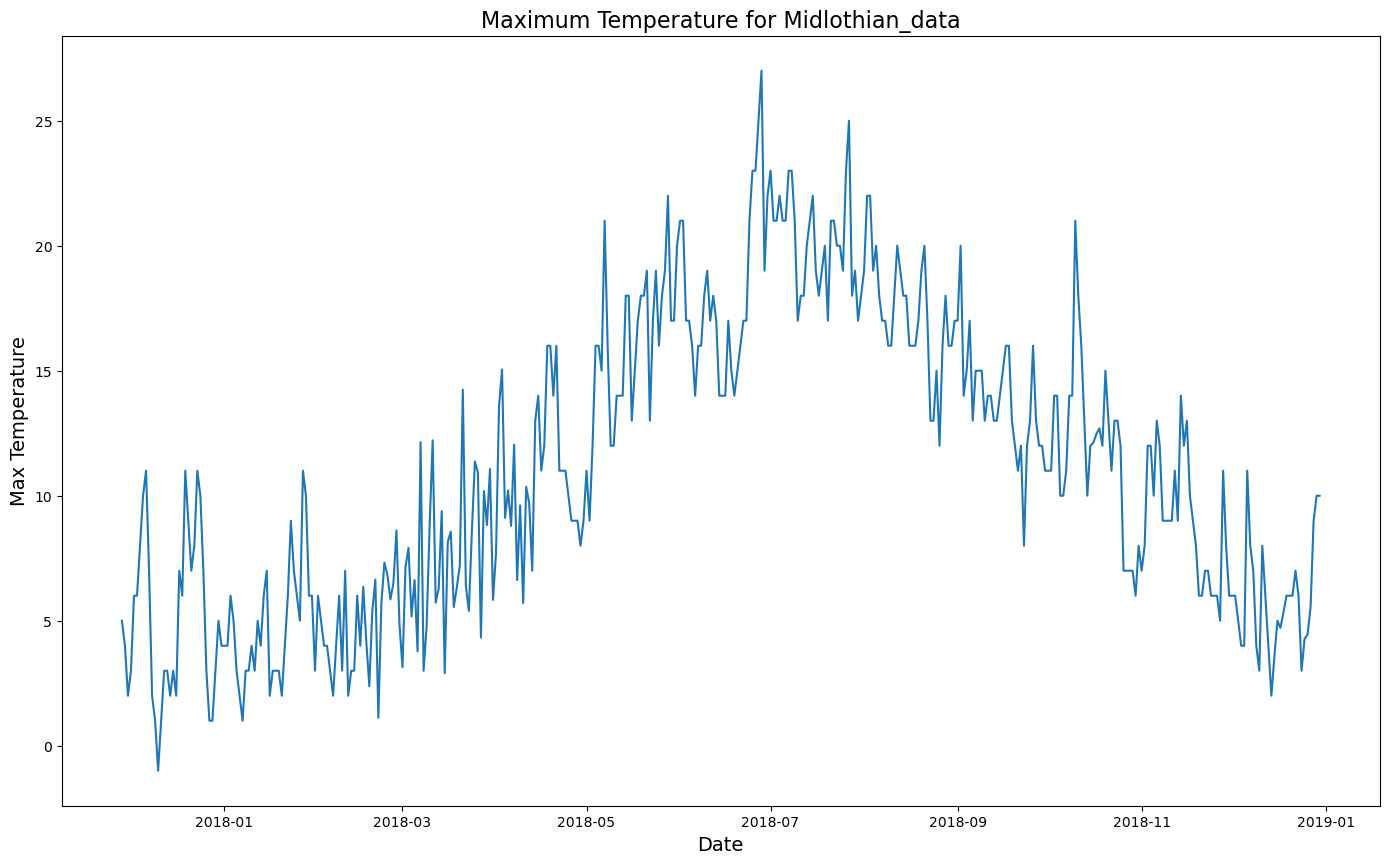

In [180]:
for loc, items in location_dataframes.items():
    plt.figure(figsize=(17,10))
    plt.plot(items.index, items['maxtemp'], linestyle='-')
    plt.title(f"Maximum Temperature for {loc}", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Max Temperature", fontsize=14)
    plt.show()

BUILD HOURLY OBSERVATIONS FOR MIN AND MAX TEMP FOR EACH LOCATION (SEPERATELY)

1. Calculate hourly timestamps for each location based on their min and max timestamp

In [181]:
def hourly_timestamps_for_each_location(location):
    hourly_timestamps = pd.date_range(start=location_dataframes[location].index.strftime('%Y-%m-%d').min(),
                                    end =location_dataframes[location].index.strftime('%Y-%m-%d').max(),
                                    freq='H')

    hourly_timestamps = pd.to_datetime(hourly_timestamps)
    hourly_timestamps = pd.DataFrame(hourly_timestamps, columns=['timestamp']) 
    
    return hourly_timestamps

hourly_timestamps_by_location = {}

for location in location_dataframes.keys():
    hourly_timestamps_by_location[f'{location}_hourly_timestamps'] = hourly_timestamps_for_each_location(location)

2. Estimate the hourly min and max temp for each location (sine function)

In [183]:
def hourly_temps_estimation(mintemp, maxtemp):
    avg_temp = np.mean([mintemp, maxtemp])
    amplitude = (np.ptp([mintemp, maxtemp]))/2
    
    t_min = 5
    hourly_temps = []
    
    for hour in range(24):
        temp = avg_temp + amplitude * (np.sin((2 * np.pi * (hour-t_min))/24 - (5 * np.pi / 12)))
        
        hourly_temps.append(temp)
    
    return hourly_temps

In [184]:
hourly_temps_by_location_dict = {}

for location in location_dataframes.keys():

    hourly_temps_by_location_dict[location] = {}
    
    for date, row in location_dataframes[location].iterrows():
        # Store hourly temperature estimates for each date
        hourly_temps_by_location_dict[location][date] = hourly_temps_estimation(row['mintemp'], row['maxtemp'])

In [ ]:
# Define function to retrieve temperature based on timestamp
def get_temperature(ts, hourly_temps_dict, location):
    # converts the timestamps of hourly_timestamp (hours,minutes and seconds) into midnight time to match the key of hourly_temps_dict and stores it to a variable
    date_key = ts.normalize()
    
    # for each normalised date_key, it returns the temperature that corresponds to the 'hour' component of the hourly_timestamps 
    # which means that if the ts.hour is 15 then it will extract the 15th element of the dictionary to match it.
    if location in hourly_temps_dict:
        
        if date_key in hourly_temps_dict[location]:

            # Fetch temperature for the hour
            return hourly_temps_dict[location][date_key][ts.hour]
        else:
            print(f"Date '{date_key}' NOT found for location '{location}'.")
    else:
        print(f"Location '{location}' NOT found in hourly_temps_dict.")

    # Return None if no match is found
    return None

# Iterate through locations and assign temperature
for location_with_suffix in hourly_timestamps_by_location.keys():
    # Extract the base location name
    location = location_with_suffix.replace('_hourly_timestamps', '')

    # Get the DataFrame for the current location
    location_df = hourly_timestamps_by_location[location_with_suffix]

    # Apply the temperature assignment
    location_df['temperature'] = location_df['timestamp'].apply(
        get_temperature, args=(hourly_temps_by_location_dict, location)
    )

    # Update the dictionary with the modified DataFrame
    hourly_timestamps_by_location[location_with_suffix] = location_df

Plot hourly temperatures for each location

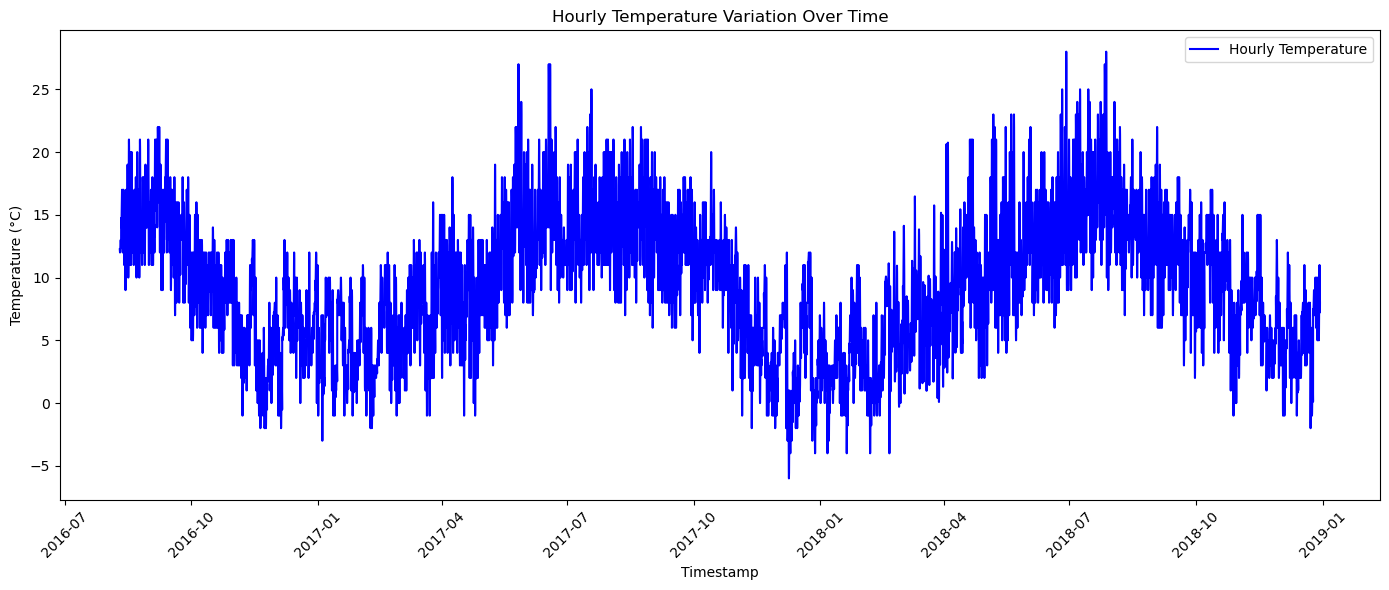

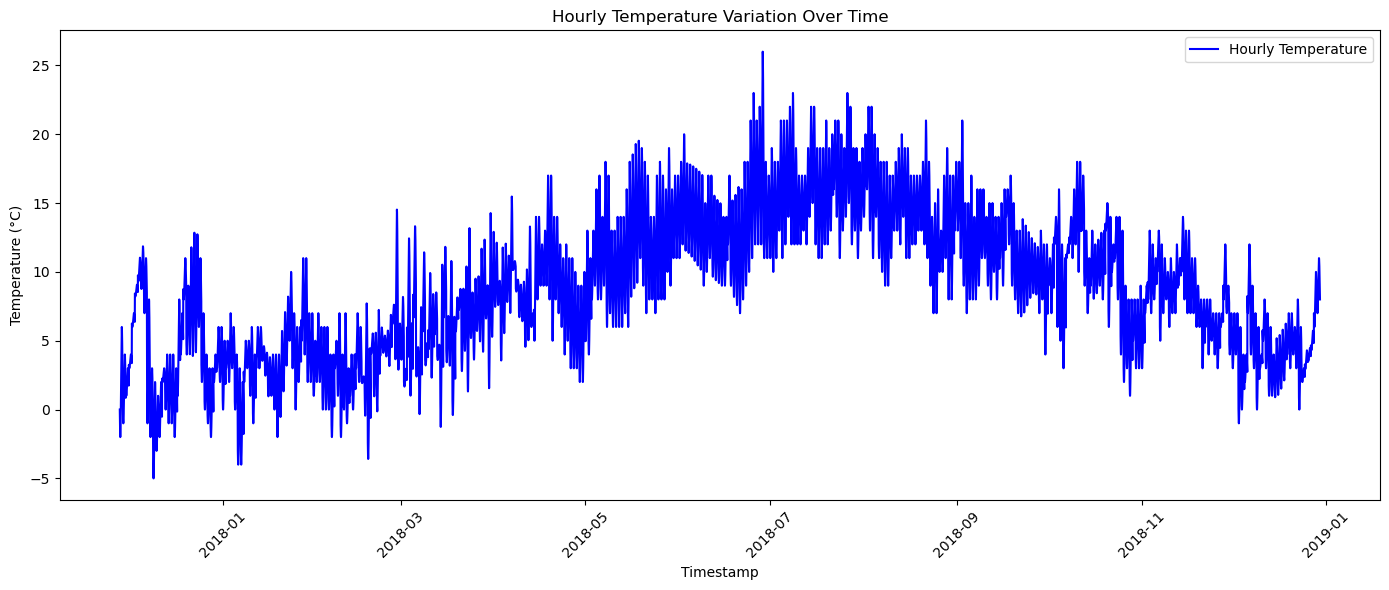

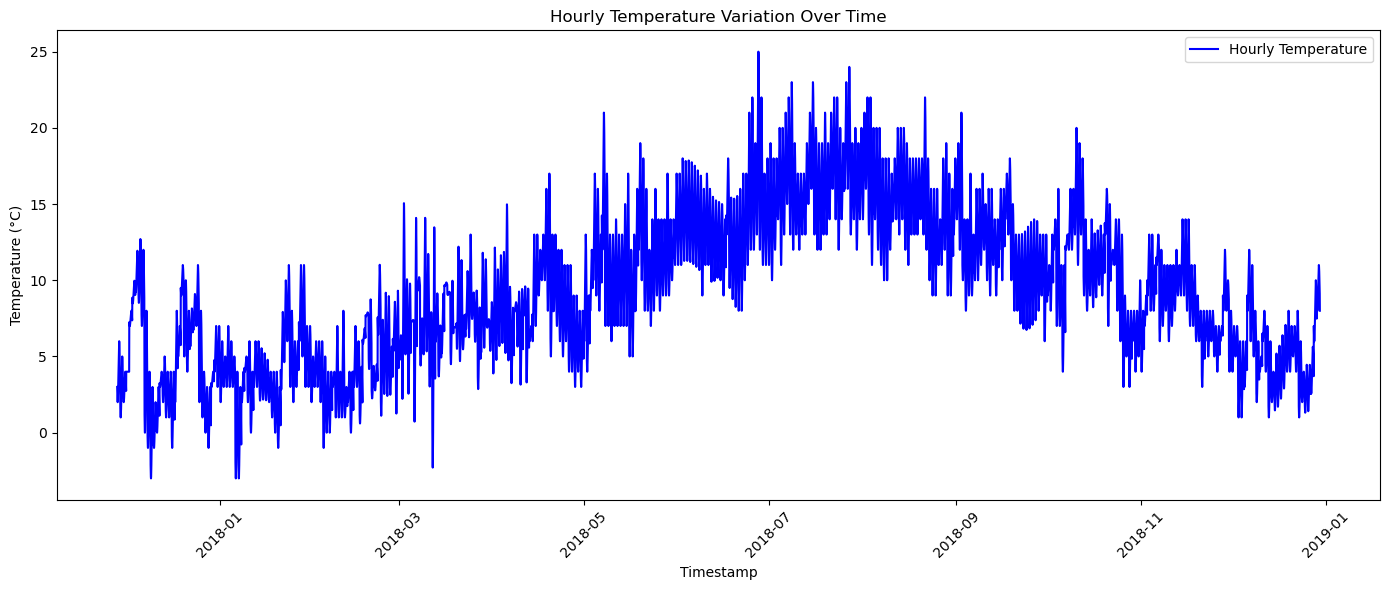

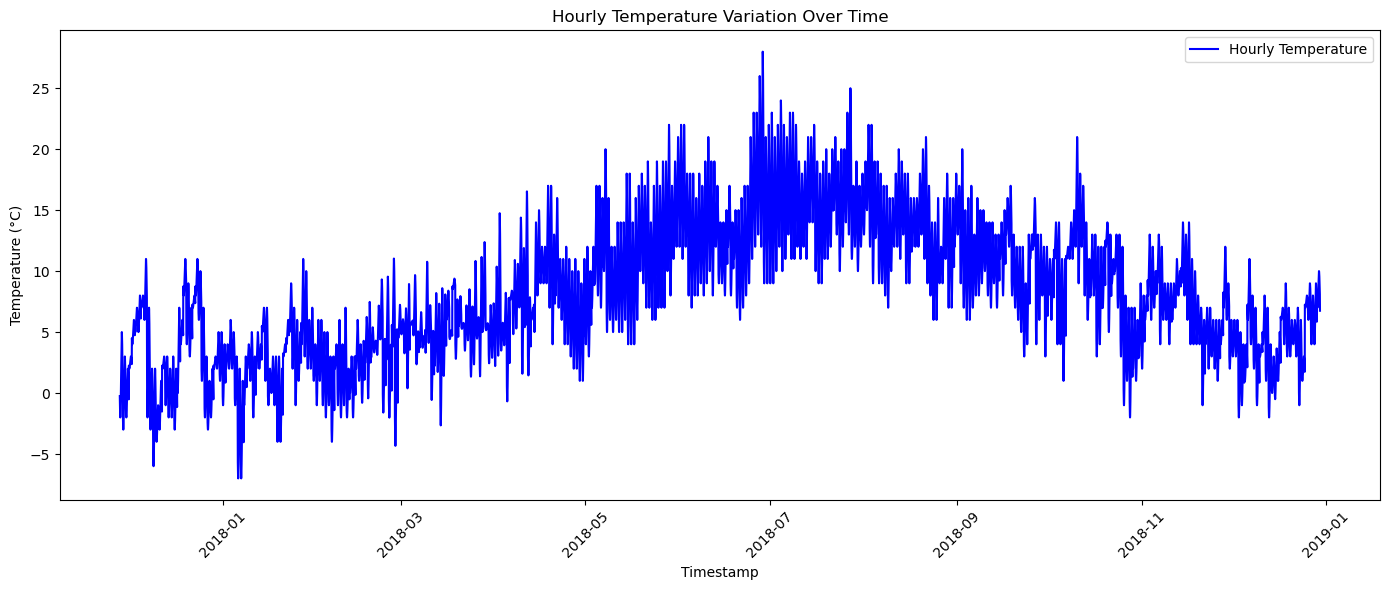

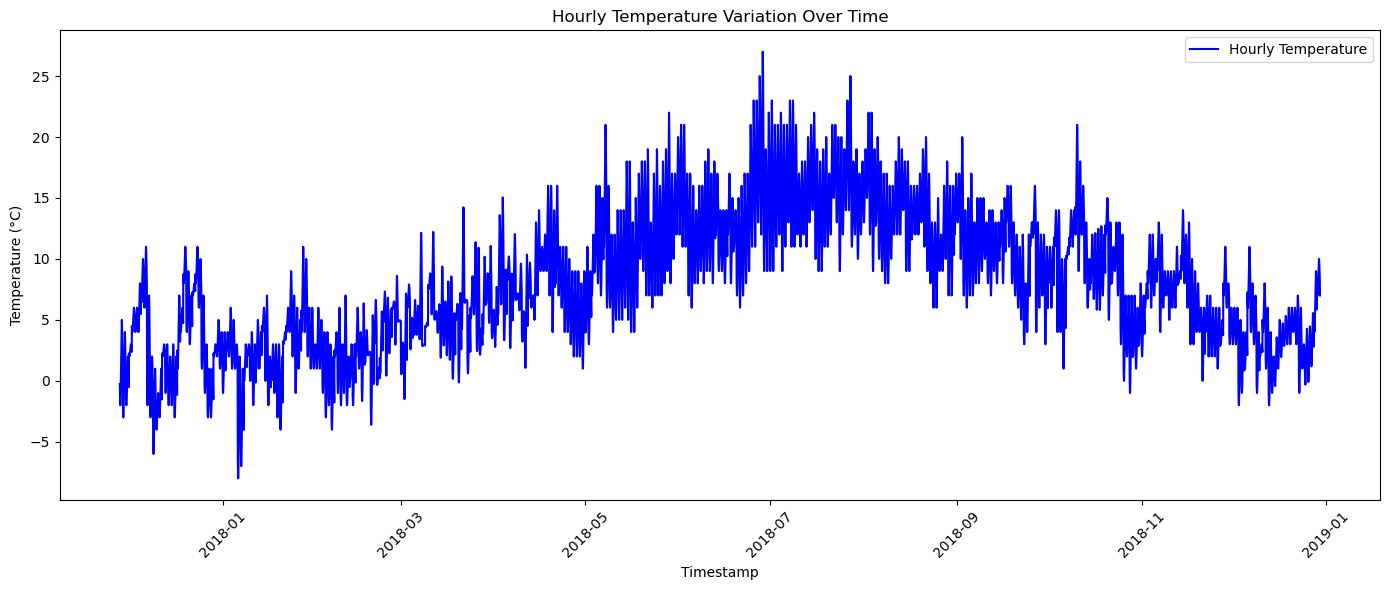

In [194]:
for location, temps in hourly_timestamps_by_location.items():
    hourly_timestamps_by_location[location]['timestamp'] = pd.to_datetime(hourly_timestamps_by_location[location]['timestamp'])
    plt.figure(figsize=(14, 6))
    plt.plot(hourly_timestamps_by_location[location]['timestamp'], hourly_timestamps_by_location[location]['temperature'], color='blue', label='Hourly Temperature')
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature (°C)')
    plt.title('Hourly Temperature Variation Over Time')
    plt.legend()
    plt.xticks(rotation=45) 
    plt.tight_layout()  
    plt.show()

Store the data in seperate CSV files for each location

In [200]:
for location_with_suffix, df in hourly_timestamps_by_location.items():
    
    base_location = location_with_suffix.replace('_hourly_timestamps', '')
    filename = f"hourly_temperatures_{base_location}.csv"
    df.to_csv(filename, index=False)

SINE FUNCTION WITH MONTE CARLO SIMULATION (FOR NOISE) (OPTIONAL)

In [23]:
def sine_function(hour, avg_temp, amplitude):

    t_min = 5

    temp = avg_temp + amplitude * np.sin((2 * np.pi * (hour - t_min)) / 24 - (5 * np.pi / 12))
    
    return temp

In [30]:
def monte_carlo_simulation(row,hourly_trend_pattern, amplitude, avg_temp, residual_std, n_simulations=5):
  
    if pd.isnull(row['temperature']):
        
        hour = row.name.hour
        simulated_values = []
        
        for _ in range(n_simulations):
            
            sine_value = sine_function(hour, avg_temp, amplitude*0.3)
            
            trend = hourly_trend_pattern[hour]
            
            random_noise = np.random.normal(0, residual_std* 2.5)
            
            simulated_value = sine_value + trend + random_noise
            simulated_values.append(simulated_value)
           
        return float(np.mean(simulated_values))   
    else:
        return row['temperature']
        